In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Для машинного перекладу
#pip install keras_nlp
import keras_nlp
import pathlib
import random
import tensorflow as tf

#pip install rogue-score

from tensorflow import keras
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

# Для Hugging face transformers
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Для генерації зображень GAN
from skimage import color
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

from os import listdir
from os.path import isfile, join

import os
import sys
from tensorflow import keras
from tensorflow.keras import layers
from keras import optimizers
from keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Dropout, LeakyReLU, BatchNormalization, Reshape

## Translation Swedish-English

Source: https://keras.io/examples/nlp/neural_machine_translation_with_keras_nlp/

In [2]:
BATCH_SIZE = 64
EPOCHS = 5  # This should be at least 10 for convergence
MAX_SEQUENCE_LENGTH = 40
ENG_VOCAB_SIZE = 15000
SWE_VOCAB_SIZE = 15000

EMBED_DIM = 256
INTERMEDIATE_DIM = 2048
NUM_HEADS = 8

In [3]:
text_file = pathlib.Path("swe.txt")

In [4]:
with open(text_file, encoding='UTF-8') as f:
    lines = f.read().strip().split("\n")[:-1]
    
text_pairs = []
for line in lines:
    eng, swe, er = line.split("\t")
    eng = eng.lower()
    swe = swe.lower()
    text_pairs.append((eng, swe))

In [5]:
for _ in range(5):
    print(random.choice(text_pairs))

('keep smiling.', 'fortsätt le.')
("i'm going to cut down on meat.", 'jag kommer att skära ner på kött.')
('how do you know i even want that job?', 'hur vet du att jag ens vill ha jobbet?')
('can we trust you?', 'kan vi lita på dig?')
('who else is in there?', 'vem mer är därinne?')


In [6]:
# split the sentence pairs into a training set, a validation set, and a test set

random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

22186 total pairs
15532 training pairs
3327 validation pairs
3327 test pairs


In [7]:
def train_word_piece(text_samples, vocab_size, reserved_tokens):
    bert_vocab_args = dict(
        # The target vocabulary size
        vocab_size=vocab_size,
        # Reserved tokens that must be included in the vocabulary
        reserved_tokens=reserved_tokens,
        # Arguments for `text.BertTokenizer`
        bert_tokenizer_params={"lower_case": True},
    )

    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)
    vocab = bert_vocab.bert_vocab_from_dataset(
        word_piece_ds.batch(1000).prefetch(2), **bert_vocab_args
    )
    return vocab

In [8]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

eng_samples = [text_pair[0] for text_pair in train_pairs]
eng_vocab = train_word_piece(eng_samples, ENG_VOCAB_SIZE, reserved_tokens)

swe_samples = [text_pair[1] for text_pair in train_pairs]
swe_vocab = train_word_piece(swe_samples, SWE_VOCAB_SIZE, reserved_tokens)

In [9]:
print("English Tokens: ", eng_vocab[100:110])
print("Swedish Tokens: ", swe_vocab[100:110])

English Tokens:  ['need', '##d', 've', 'why', 'just', 'up', 'now', 'very', 'who', '##y']
Swedish Tokens:  ['##et', 'ska', 'tycker', 'ha', '##d', 'din', 'ut', 'mycket', 'nu', 'vara']


In [10]:
# define the tokenizers

eng_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=eng_vocab, lowercase=False
)
swe_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=swe_vocab, lowercase=False
)

In [11]:
# tokenize a sample from our dataset

eng_input_ex = text_pairs[1][0]
eng_tokens_ex = eng_tokenizer.tokenize(eng_input_ex)
print("English sentence: ", eng_input_ex)
print("Tokens: ", eng_tokens_ex)
print("Recovered text after detokenizing: ", eng_tokenizer.detokenize(eng_tokens_ex))

print()

swe_input_ex = text_pairs[1][1]
swe_tokens_ex = swe_tokenizer.tokenize(swe_input_ex)
print("Swedish sentence: ", swe_input_ex)
print("Tokens: ", swe_tokens_ex)
print("Recovered text after detokenizing: ", swe_tokenizer.detokenize(swe_tokens_ex))

English sentence:  i would like to talk with you again.
Tokens:  tf.Tensor([ 31 138  75  54 173  93  52 211  10], shape=(9,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'i would like to talk with you again .', shape=(), dtype=string)

Swedish sentence:  jag skulle vilja prata med dig igen.
Tokens:  tf.Tensor([ 51  89 189 206  72  71 174  10], shape=(8,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'jag skulle vilja prata med dig igen .', shape=(), dtype=string)


In [12]:
# format our datasets

def preprocess_batch(eng, swe):
    batch_size = tf.shape(swe)[0]

    eng = eng_tokenizer(eng)
    swe = swe_tokenizer(swe)

    # Pad `eng` to `MAX_SEQUENCE_LENGTH`.
    eng_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value=eng_tokenizer.token_to_id("[PAD]"),
    )
    eng = eng_start_end_packer(eng)

    # Add special tokens (`"[START]"` and `"[END]"`) to `swe` and pad it as well.
    swe_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH + 1,
        start_value=swe_tokenizer.token_to_id("[START]"),
        end_value=swe_tokenizer.token_to_id("[END]"),
        pad_value=swe_tokenizer.token_to_id("[PAD]"),
    )
    swe = swe_start_end_packer(swe)

    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": swe[:, :-1],
        },
        swe[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, swe_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    swe_texts = list(swe_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, swe_texts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [13]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 40)
inputs["decoder_inputs"].shape: (64, 40)
targets.shape: (64, 40)


In [14]:
# Building the model

# Encoder
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=ENG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=SWE_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(SWE_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

transformer = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="transformer",
)

N:\python_dataset\pythonNeuralNet\venv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [15]:
EPOCHS = 12
transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 token_and_position_embedding (  (None, None, 256)   3850240     ['encoder_inputs[0][0]']         
 TokenAndPositionEmbedding)                                                                       
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   1315072     ['token_and_position_em

In [16]:
# Decoding test sentences

def decode_sequences(input_sentences):
    batch_size = tf.shape(input_sentences)[0]

    # Tokenize the encoder input.
    encoder_input_tokens = eng_tokenizer(input_sentences).to_tensor(
        shape=(None, MAX_SEQUENCE_LENGTH)
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(decoder_input_tokens):
        return transformer([encoder_input_tokens, decoder_input_tokens])[:, -1, :]

    # Set the prompt to the "[START]" token.
    prompt = tf.fill((batch_size, 1), swe_tokenizer.token_to_id("[START]"))

    generated_tokens = keras_nlp.utils.greedy_search(
        token_probability_fn,
        prompt,
        max_length=40,
        end_token_id=swe_tokenizer.token_to_id("[END]"),
    )
    generated_sentences = swe_tokenizer.detokenize(generated_tokens)
    return generated_sentences


test_eng_texts = [pair[0] for pair in test_pairs]
for i in range(2):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequences(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8")
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )
    print(f"** Example {i} **")
    print(input_sentence)
    print(translated)
    print()

** Example 0 **
what is this for?
vad ar det har for ?

** Example 1 **
tom didn't visit boston.
tom besokte inte boston .



In [17]:
# Evaluating our model

rouge_1 = keras_nlp.metrics.RougeN(order=1)
rouge_2 = keras_nlp.metrics.RougeN(order=2)

for test_pair in test_pairs[:30]:
    input_sentence = test_pair[0]
    reference_sentence = test_pair[1]

    translated_sentence = decode_sequences(tf.constant([input_sentence]))
    translated_sentence = translated_sentence.numpy()[0].decode("utf-8")
    translated_sentence = (
        translated_sentence.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )

    rouge_1(reference_sentence, translated_sentence)
    rouge_2(reference_sentence, translated_sentence)

print("ROUGE-1 Score: ", rouge_1.result())
print("ROUGE-2 Score: ", rouge_2.result())

ROUGE-1 Score:  {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4666137>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.37507454>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.41136914>}
ROUGE-2 Score:  {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.13218254>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.10732193>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.11732028>}


## Hugging face transformers

In [ ]:
classifier = pipeline('sentiment-analysis')

In [ ]:
txt_1 = 'This movie was so good'
classifier(txt_1)

In [ ]:
txt_2 = 'This was the most boring movie I`ve ever seen'
classifier(txt_2)

In [ ]:
txt_3 = 'The movie could be better'
classifier(txt_3)

In [ ]:
txt_4 = 'I didn`t expect much from this movie so I wasn`t disappointed'
classifier(txt_4)

In [ ]:
# AutoTokenizer, TFAutoModelForSequenceClassification

model_name = "ProsusAI/finbert"
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
classifier = pipeline('sentiment-analysis', model = model, tokenizer = tokenizer)

In [ ]:
txt_1 = 'This movie was so good'
classifier(txt_1)

In [ ]:
txt_2 = 'This was the most boring movie I`ve ever seen'
classifier(txt_2)

In [ ]:
txt_3 = 'The movie could be better'
classifier(txt_3)

In [ ]:
txt_4 = 'I didn`t expect much from this movie so I wasn`t disappointed'
classifier(txt_4)

In [ ]:
inputs = tokenizer([txt_1, txt_2, txt_3, txt_4])
inputs

In [ ]:
tokens = tokenizer.tokenize(txt_4)
tokens

In [ ]:
print(tokenizer.convert_tokens_to_ids(tokens))
print(tokenizer.decode(tokenizer.convert_tokens_to_ids(tokens)))

## Генерації зображень GAN

Посилання на датасет:
https://www.kaggle.com/datasets/andrewmvd/animal-faces

In [8]:
mypath_class_1='animals/cat/'
mypath_class_2='animals/dog/'
mypath_class_3='animals/wild/'

mypath_class_1_list = [mypath_class_1+f for f in listdir(mypath_class_1) if isfile(join(mypath_class_1, f))]
mypath_class_2_list = [mypath_class_2+f for f in listdir(mypath_class_2) if isfile(join(mypath_class_2, f))]
mypath_class_3_list = [mypath_class_3+f for f in listdir(mypath_class_3) if isfile(join(mypath_class_3, f))]

all_files=mypath_class_1_list+mypath_class_2_list+mypath_class_3_list

In [9]:
data=[(file_path,0) if('cat' in file_path) 
    else ((file_path,1)) if('dog' in file_path)  
    else ((file_path,2)) for file_path in all_files]

<AxesSubplot:xlabel='labels', ylabel='count'>

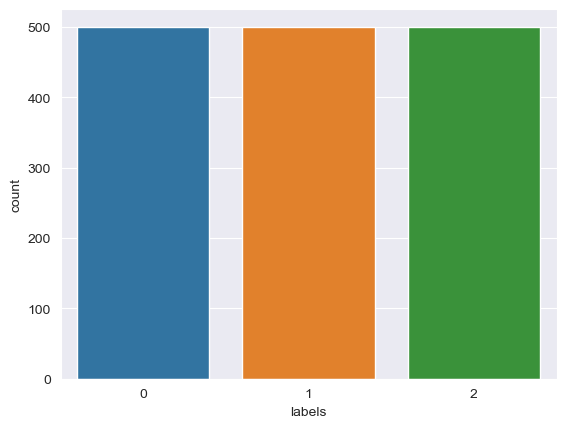

In [10]:
data=pd.DataFrame(data, columns=['path','labels'])

sns.set_style('darkgrid')
sns.countplot(x='labels',data=data)

In [11]:
types=['cat', 'dog', 'wild']
examples=[]
for i in range(3):
    examples.append(data['path'][i*500])

In [12]:
x = []
for i in range(len(examples)):
    path=examples[i]
    print (path)
    image = io.imread(path)
    image_res = resize(image, (100, 100), anti_aliasing=True)
    np_pic = np.array(image_res, dtype=np.float32)
    x.append(np_pic)

animals/cat/flickr_cat_000008.jpg
animals/dog/flickr_dog_000043.jpg
animals/wild/flickr_wild_000004.jpg


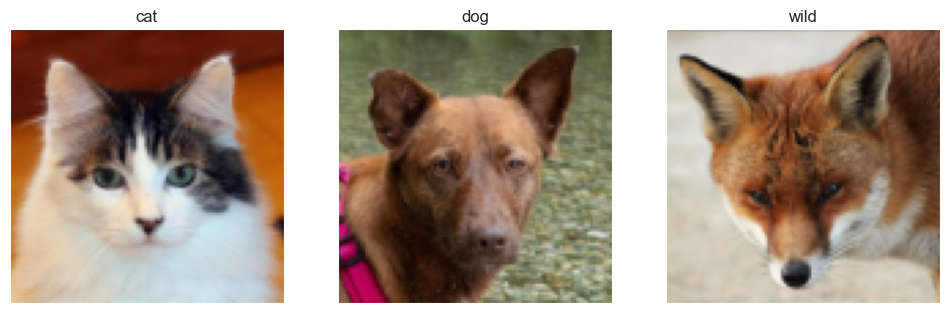

In [13]:
fig = plt.figure(figsize=(12,60))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_title(types[i])     
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(x[i])

In [14]:
x = []
y=data['labels']
for i in range(int(len(data['path'])/3)):
    path= data['path'][i*3]
    #print(path)
    image = io.imread(path)
    image_res = resize(image, (32, 32), anti_aliasing=True)
    np_pic = np.array(image_res, dtype=np.float32)
    x.append(np_pic)

In [83]:
np.save('animals.npy', x)
x = np.load('animals.npy')

In [86]:
x=np.asarray(x)
x.shape

(500, 32, 32, 3)

In [106]:
optimize = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [107]:
def discriminator():
    model = keras.Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=(32,32,3)))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optimize, metrics=['accuracy'])
    return model

In [108]:
discr=discriminator()
discr.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 256)        

In [109]:
dim = 100

def generator():
    model = keras.Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model 

In [110]:
def build_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = keras.Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optimize)
    return model

In [111]:
gener = generator()
gan = build_gan(gener, discr)

In [112]:
def plot_generate_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, dim])
    generated_images=generator.predict(noise)
    # scale from [-1,1] to [0,1]
    generated_images = (generated_images + 1) / 2.0
    
    plt.figure(figsize=(20, 4))
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [113]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [118]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x.shape[0]/batch_size)
    for ep in range(epochs+1):
        with HiddenPrints():
            for i in range(num_batches):
                noise = np.random.normal(0, 1, size=[batch_size, dim])
                image_batch = x[np.random.randint(0, x.shape[0], size=batch_size)]
            
                # Generate fake images
                generated_images = gener.predict(noise)
            
                X = np.concatenate([image_batch, generated_images])

                # Labels for generated and real data
                y_dis = np.zeros(2*batch_size)
                y_dis[:batch_size] = 0.9   #(instead of 1.0) sort of trick in GAN training, so called label smoothing
                
                # Train discriminator
                discr.trainable = True
                d_loss, _ = discr.train_on_batch(X, y_dis)
                discrim_losses.append(d_loss)

                #Train generator
                noise = np.random.normal(0, 1, size=[batch_size, dim])
                y_gen = np.ones(batch_size)
                discr.trainable = False
                gan.train_on_batch(noise, y_gen)
                
        if ep % 10 == 0:
            print('epoch: ', ep)
            plot_generate_images(ep, gener)
            tf.keras.backend.clear_session()  

epoch:  0
1/1 [==============================] - 0s 256ms/step


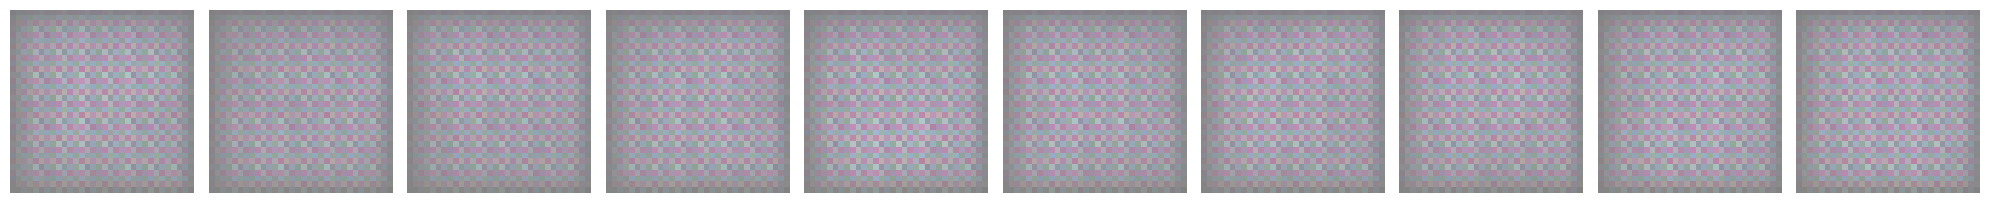

epoch:  10
1/1 [==============================] - 0s 135ms/step


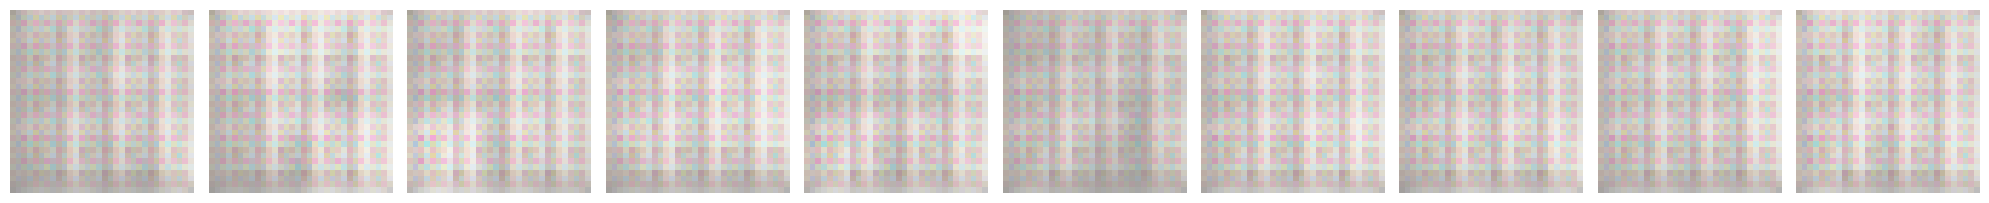

epoch:  20
1/1 [==============================] - 0s 136ms/step


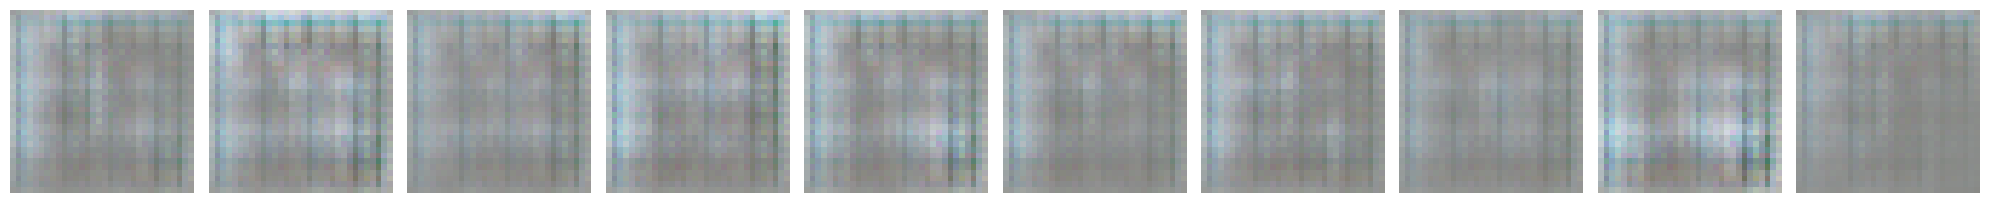

epoch:  30
1/1 [==============================] - 0s 139ms/step


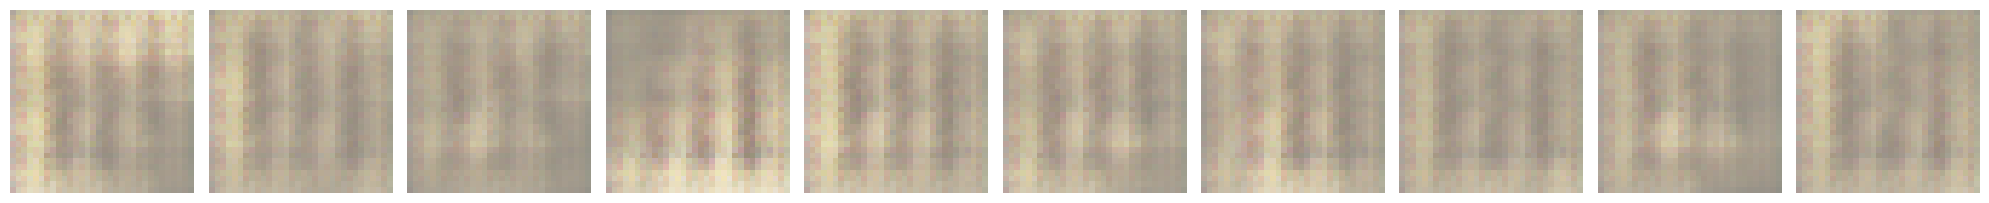

epoch:  40
1/1 [==============================] - 0s 197ms/step


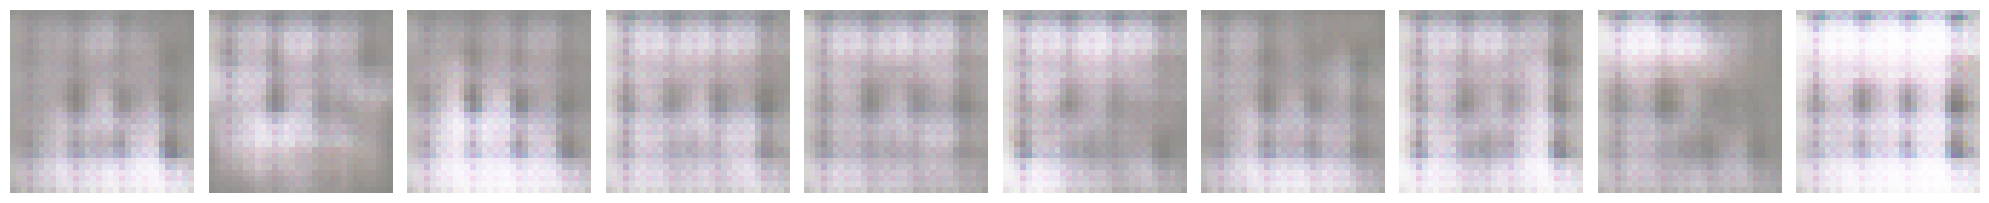

epoch:  50
1/1 [==============================] - 0s 136ms/step


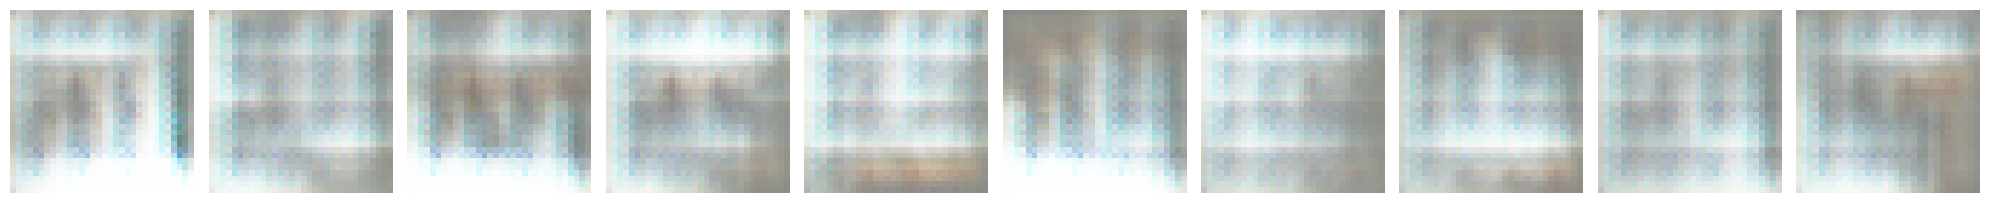

epoch:  60
1/1 [==============================] - 0s 136ms/step


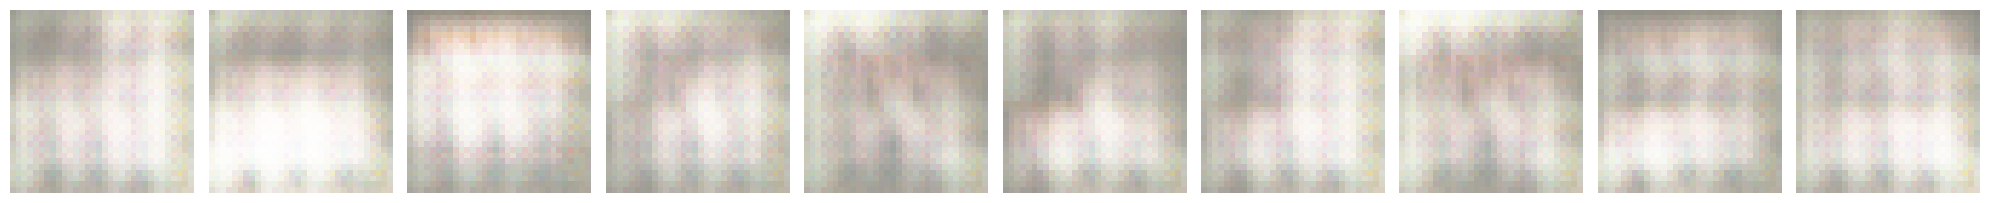

epoch:  70
1/1 [==============================] - 0s 138ms/step


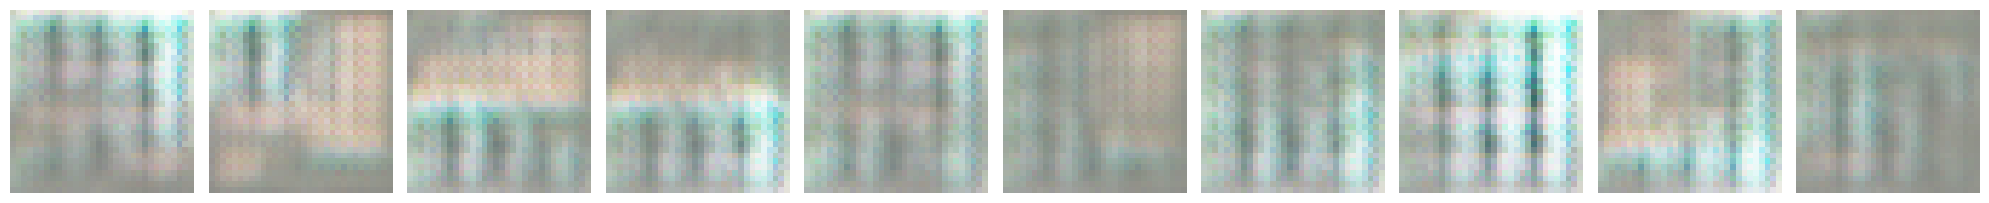

epoch:  80
1/1 [==============================] - 0s 139ms/step


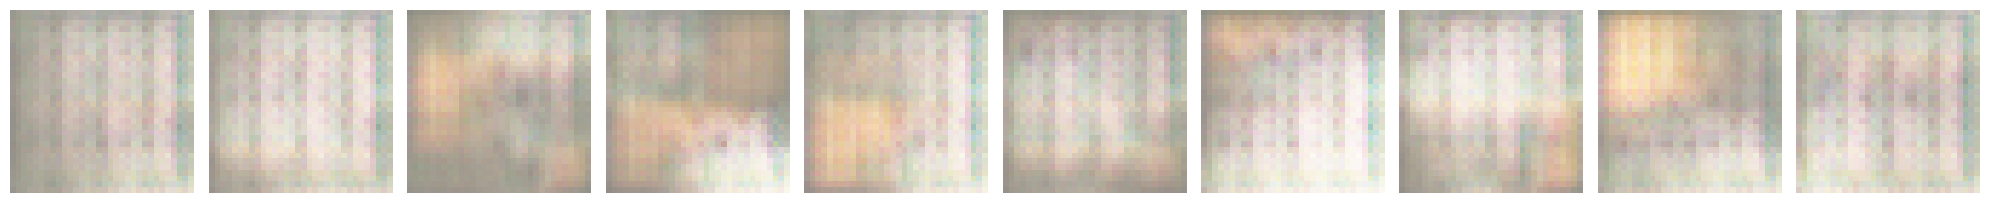

epoch:  90
1/1 [==============================] - 0s 136ms/step


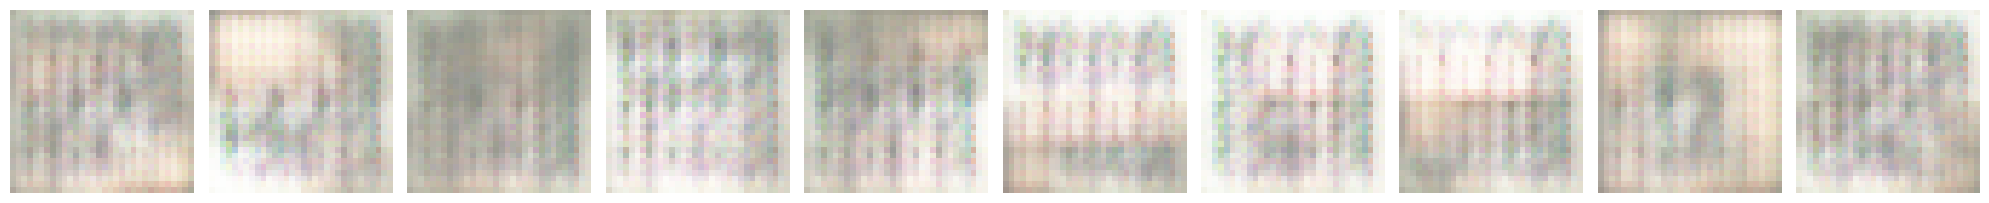

epoch:  100
1/1 [==============================] - 0s 135ms/step


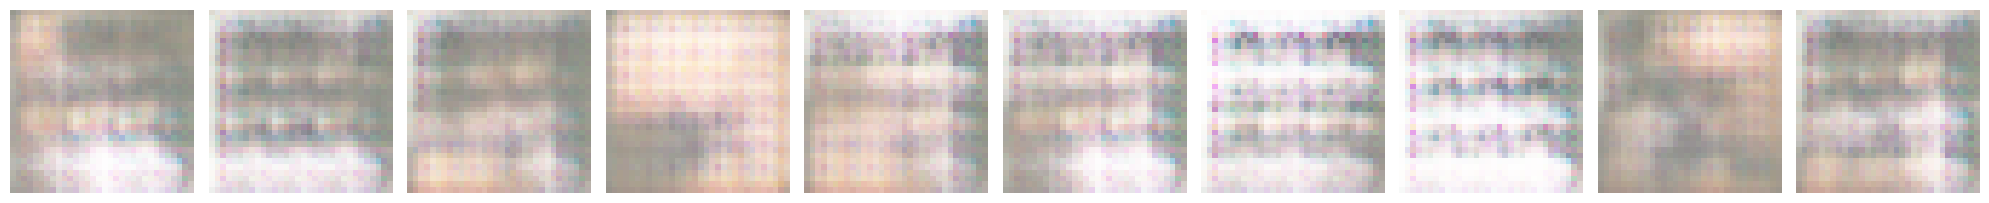

epoch:  110
1/1 [==============================] - 0s 138ms/step


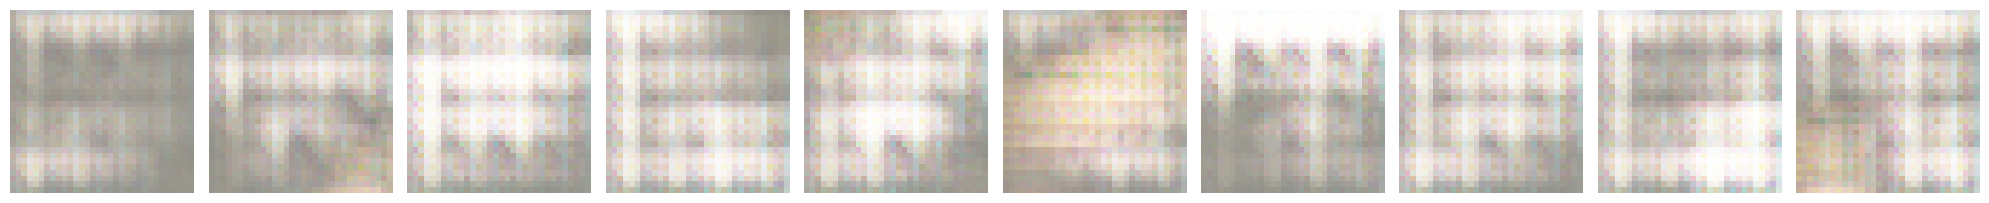

epoch:  120
1/1 [==============================] - 0s 136ms/step


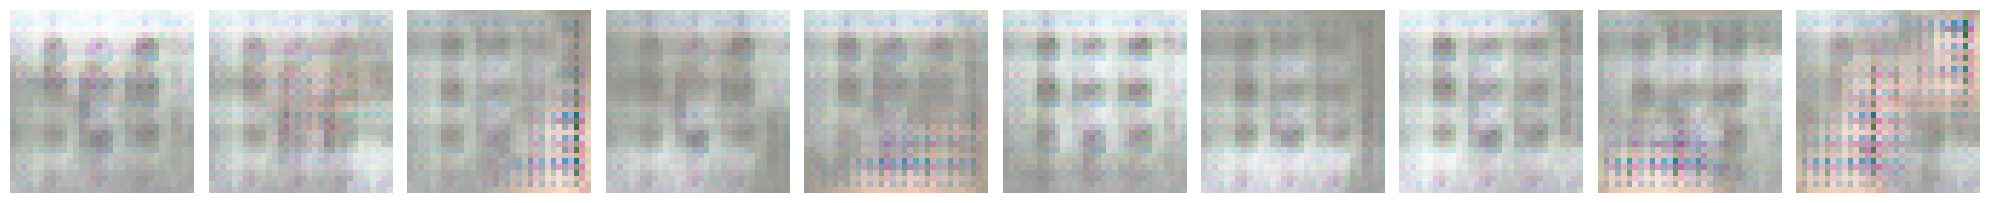

epoch:  130
1/1 [==============================] - 0s 136ms/step


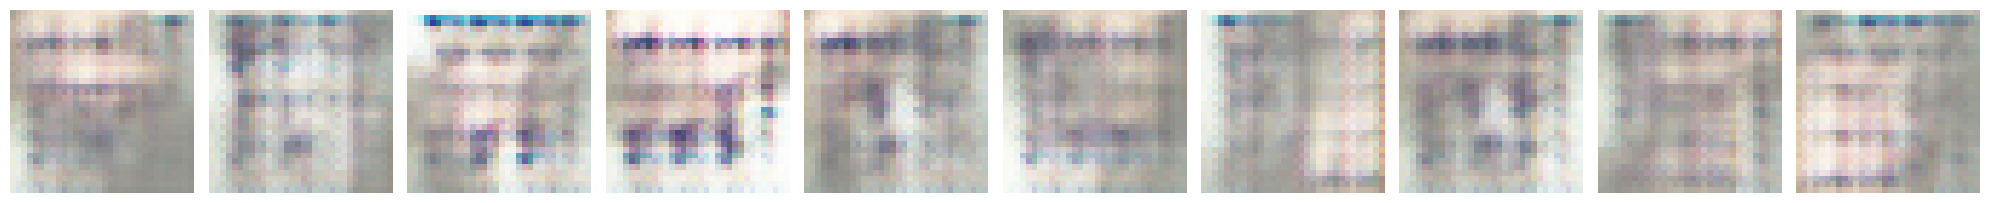

epoch:  140
1/1 [==============================] - 0s 136ms/step


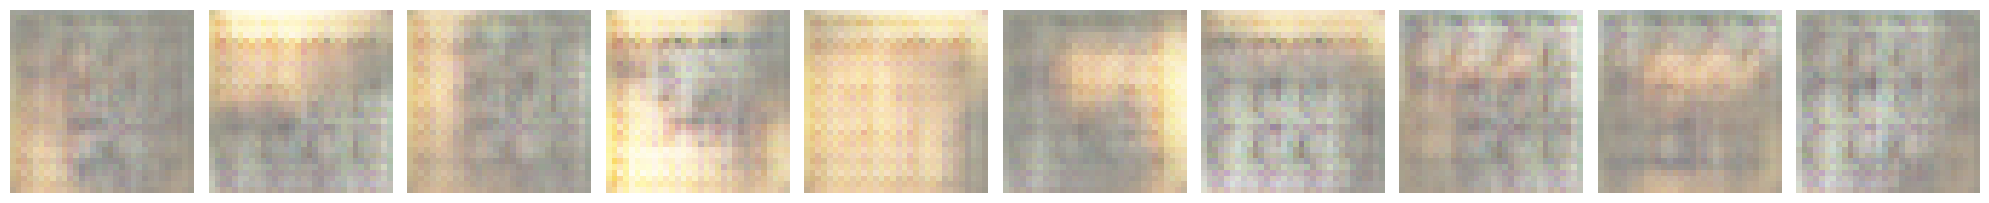

epoch:  150
1/1 [==============================] - 0s 136ms/step


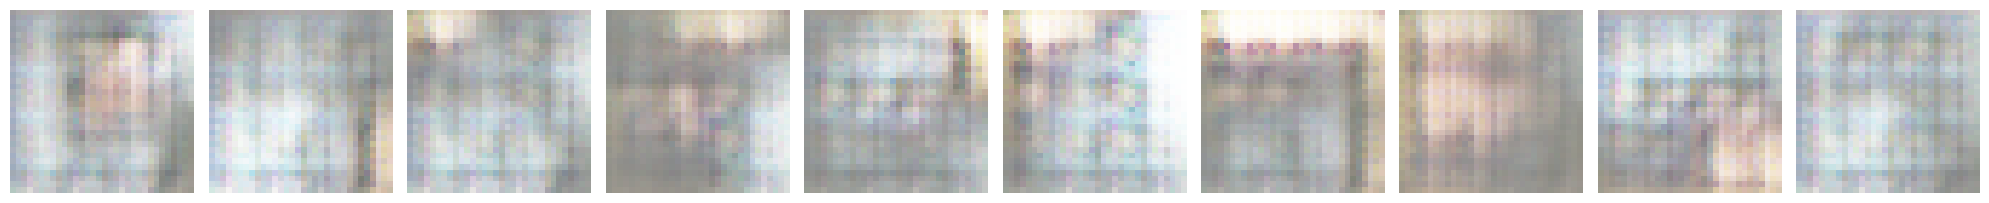

epoch:  160
1/1 [==============================] - 0s 142ms/step


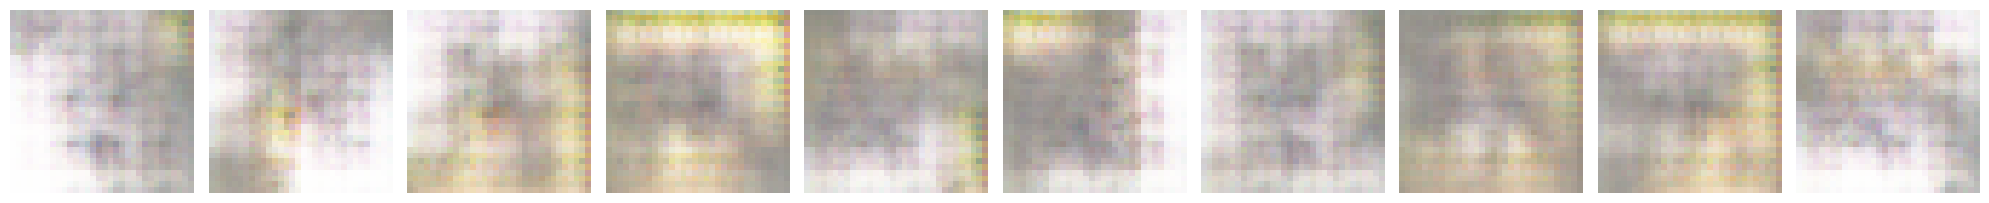

epoch:  170
1/1 [==============================] - 0s 163ms/step


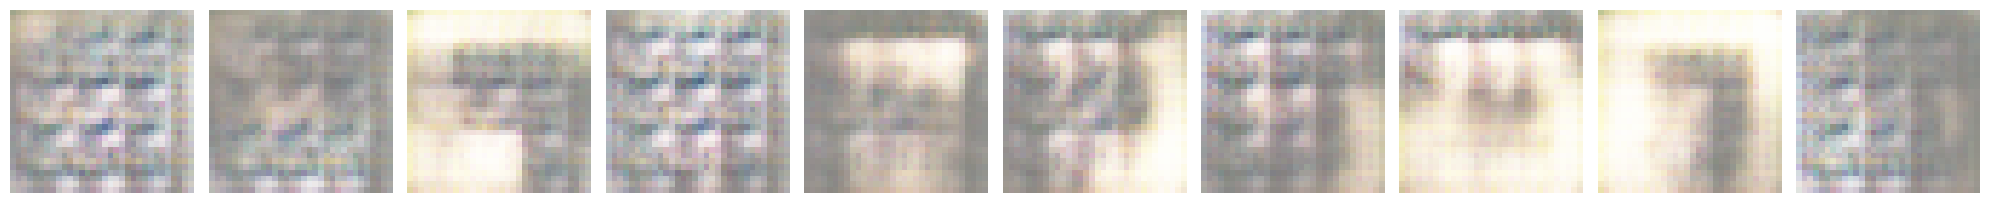

epoch:  180
1/1 [==============================] - 0s 137ms/step


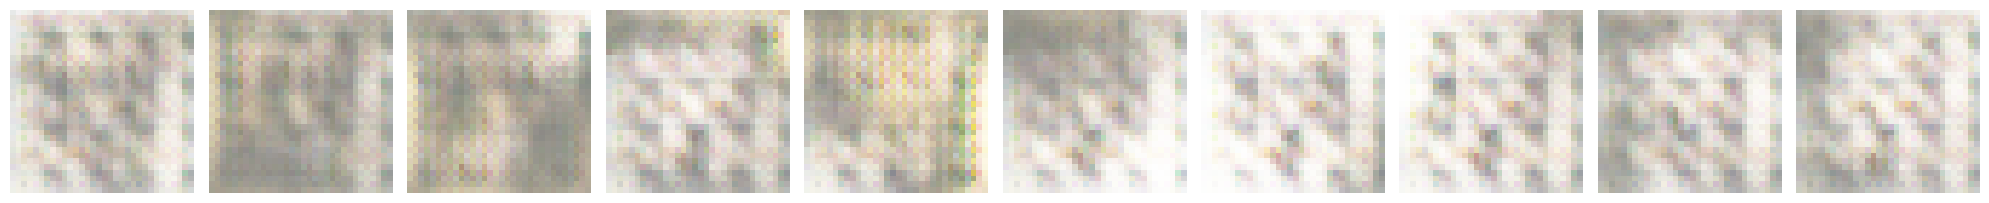

epoch:  190
1/1 [==============================] - 0s 137ms/step


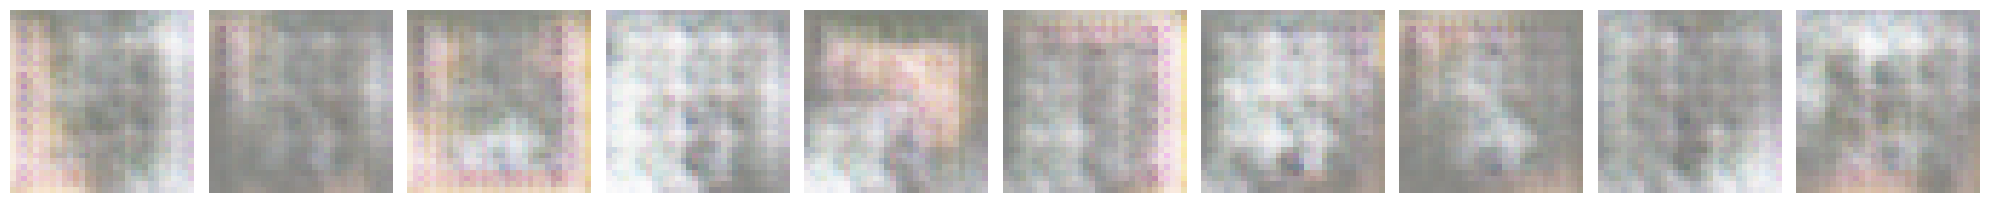

epoch:  200
1/1 [==============================] - 0s 134ms/step


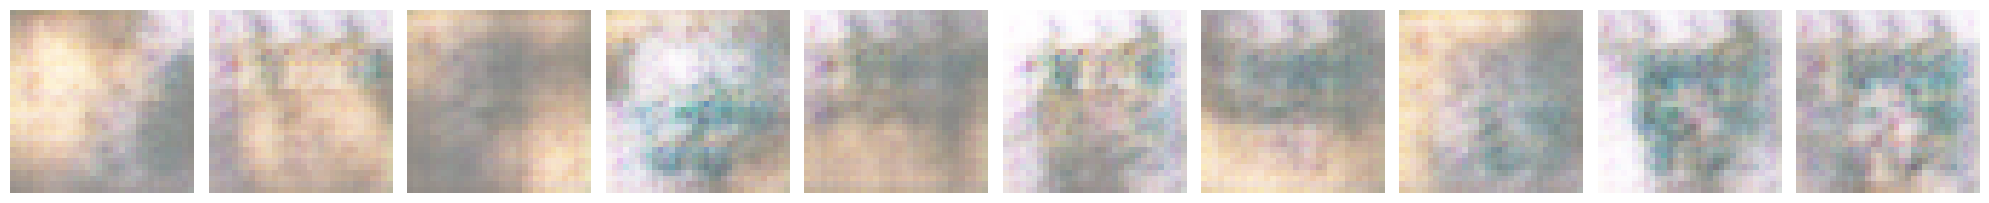

In [119]:
epochs = 200     #to get good quality images, you should train the model for more than 100 epochs
batch_size = 64
train_model(epochs, batch_size)

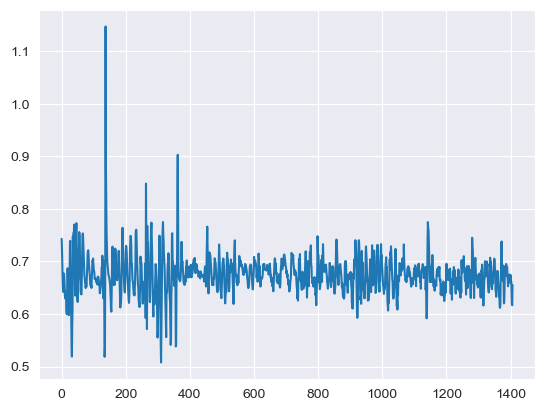

In [120]:
plt.plot(discrim_losses)

In [121]:
gan.save_weights('animals')
gan.load_weights('animals')

epoch:  0
1/1 [==============================] - 0s 137ms/step


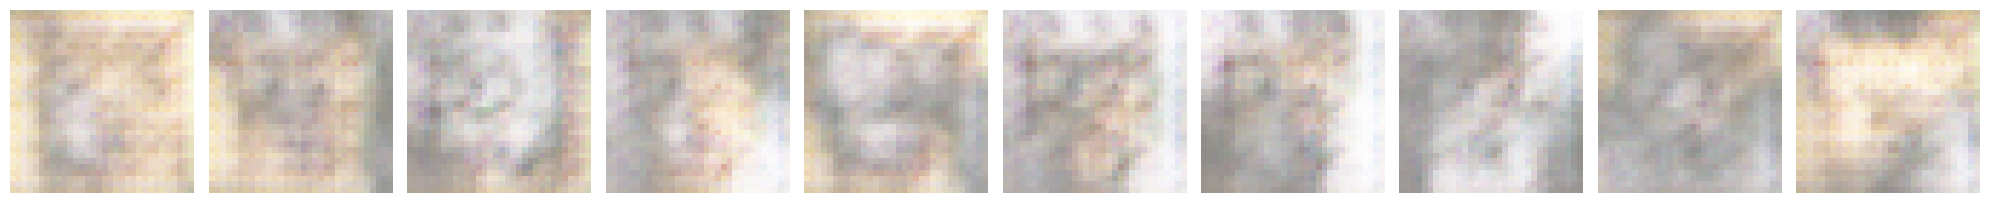

epoch:  10
1/1 [==============================] - 0s 136ms/step


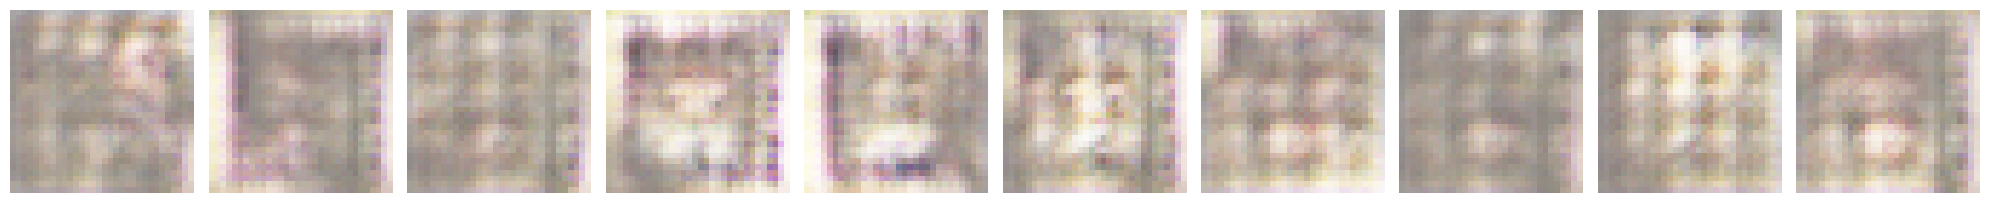

epoch:  20
1/1 [==============================] - 0s 138ms/step


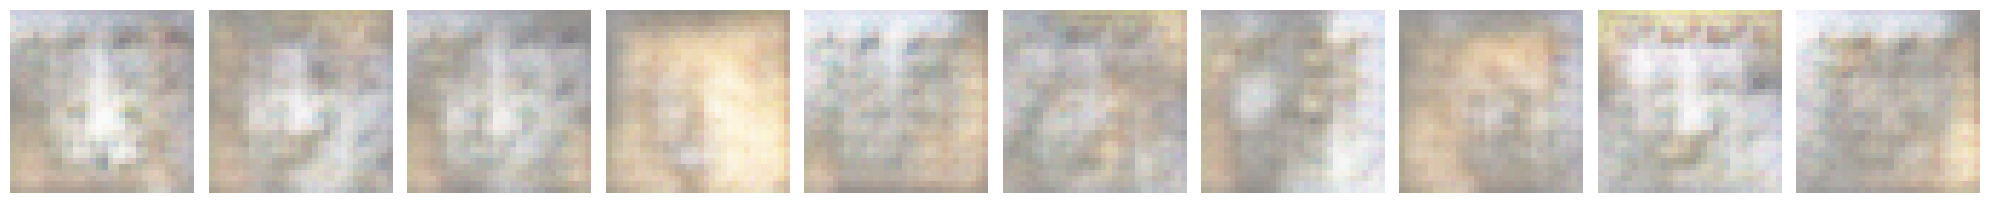

epoch:  30
1/1 [==============================] - 0s 138ms/step


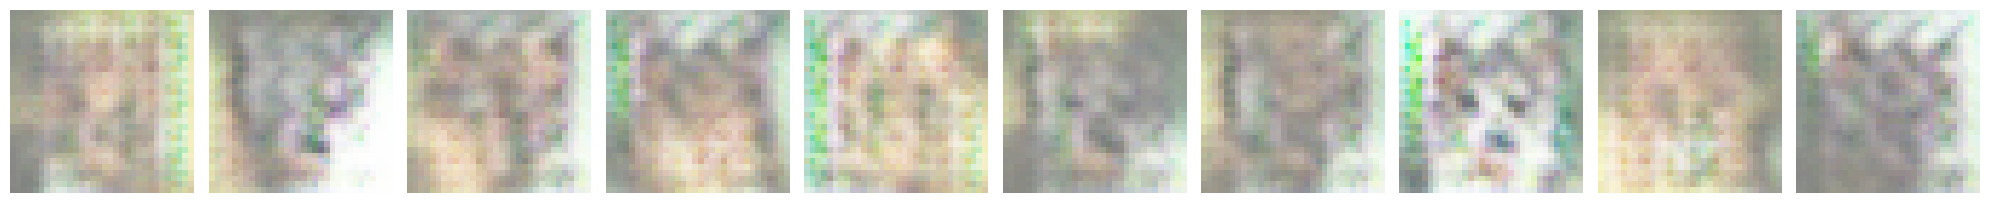

epoch:  40
1/1 [==============================] - 0s 135ms/step


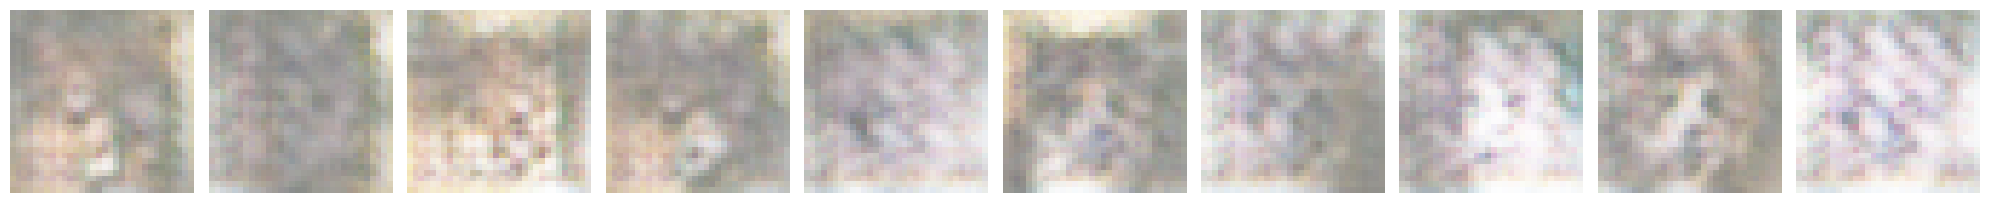

epoch:  50
1/1 [==============================] - 0s 134ms/step


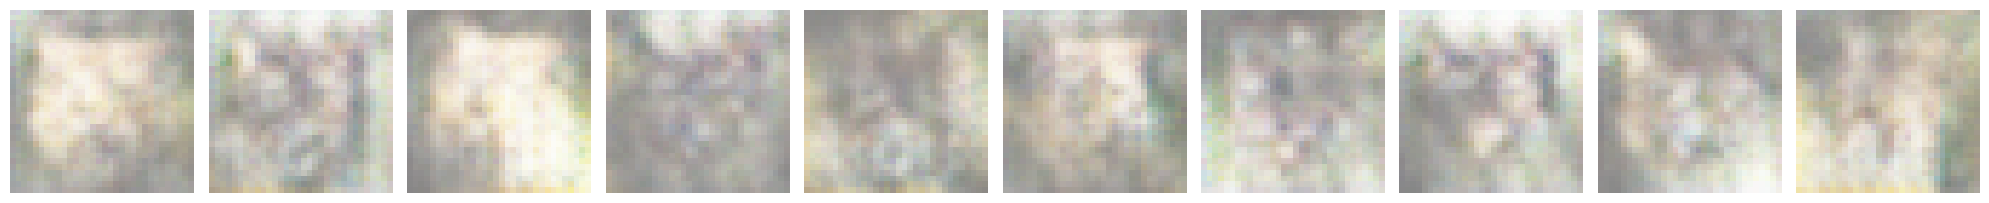

epoch:  60
1/1 [==============================] - 0s 209ms/step


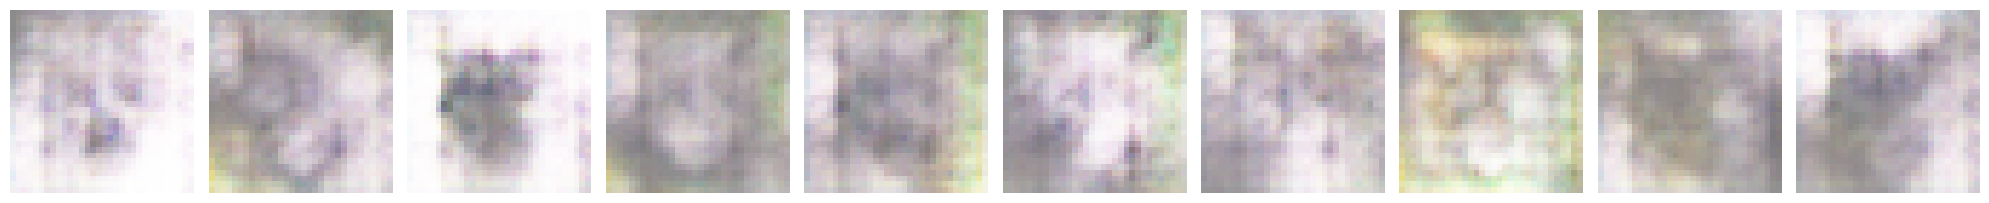

epoch:  70
1/1 [==============================] - 0s 145ms/step


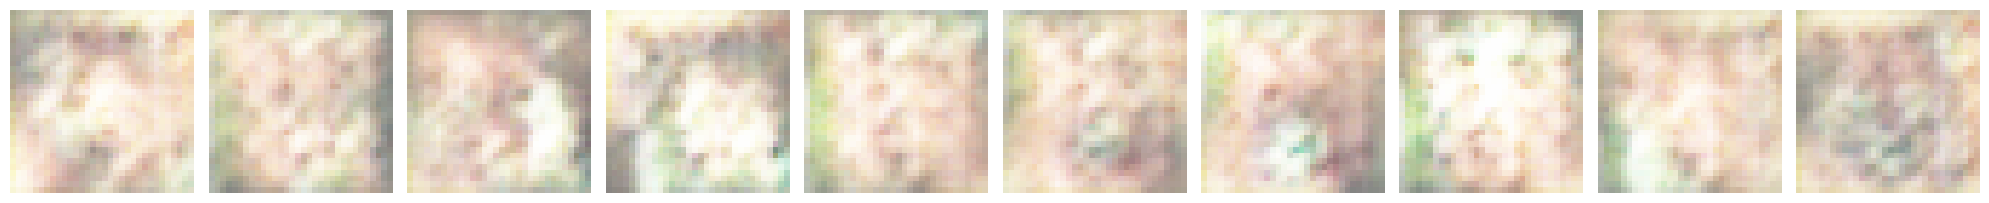

epoch:  80
1/1 [==============================] - 0s 137ms/step


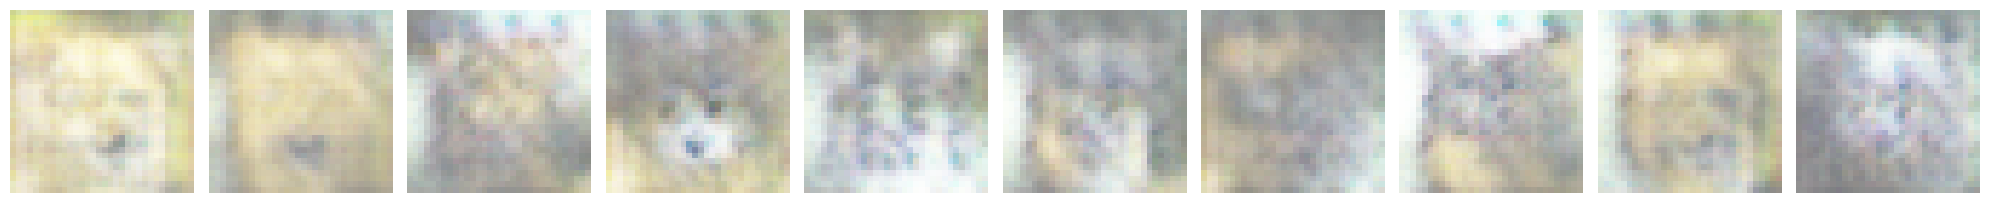

epoch:  90
1/1 [==============================] - 0s 170ms/step


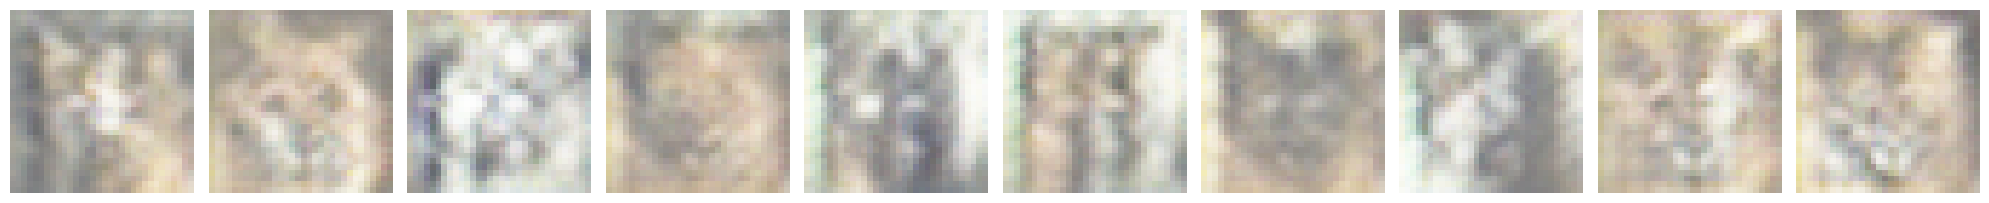

epoch:  100
1/1 [==============================] - 0s 140ms/step


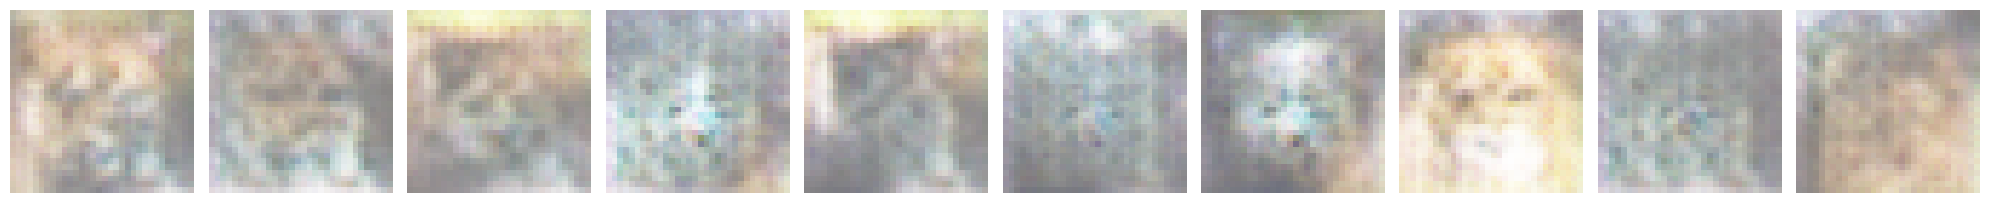

epoch:  110
1/1 [==============================] - 0s 141ms/step


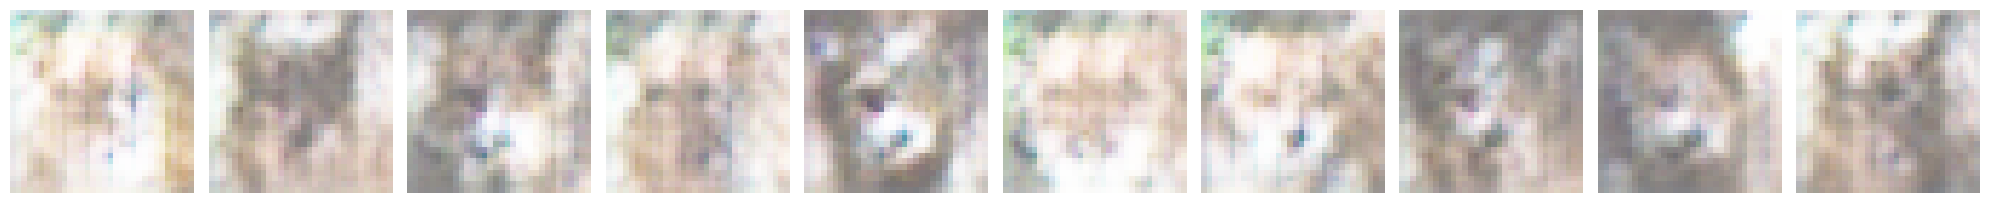

epoch:  120
1/1 [==============================] - 0s 153ms/step


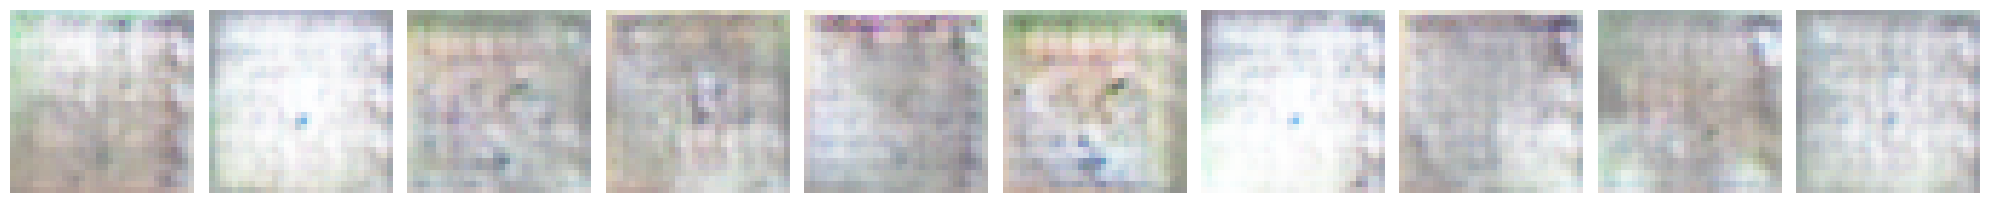

epoch:  130
1/1 [==============================] - 0s 207ms/step


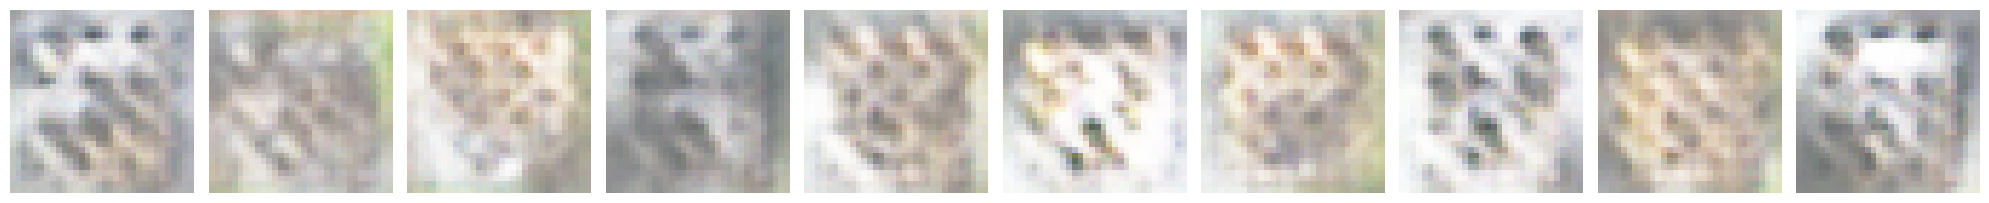

epoch:  140
1/1 [==============================] - 0s 148ms/step


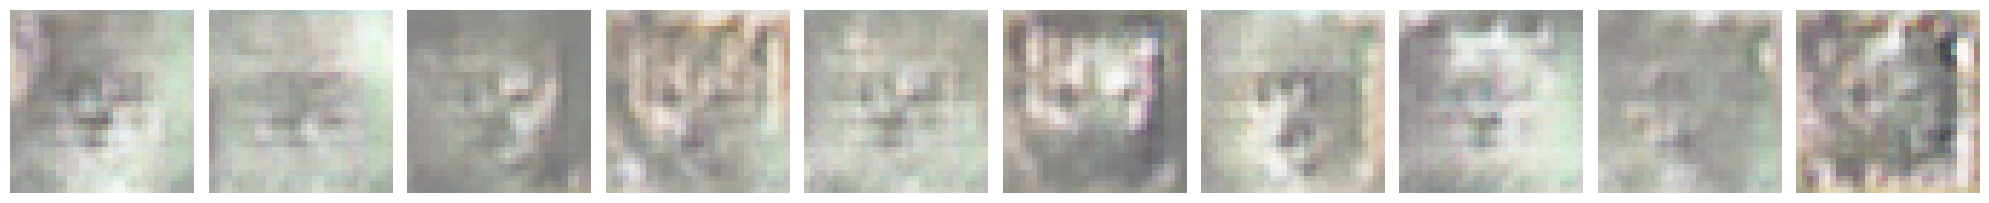

epoch:  150
1/1 [==============================] - 0s 141ms/step


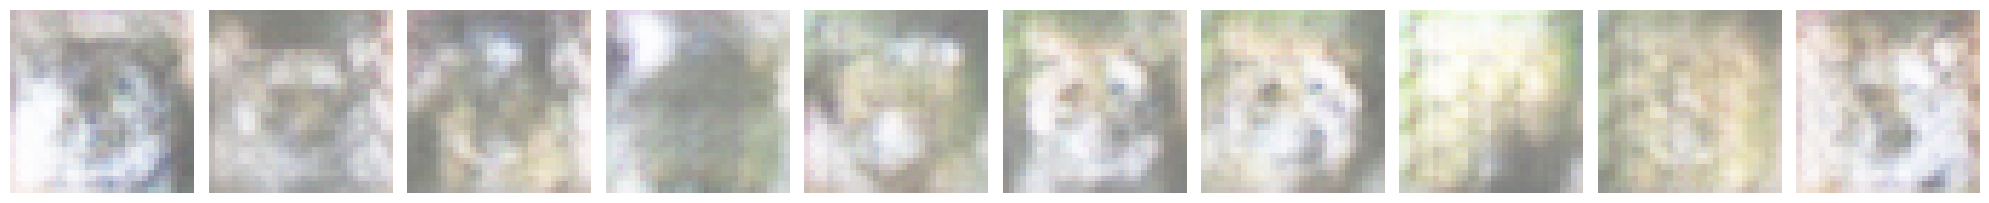

epoch:  160
1/1 [==============================] - 0s 135ms/step


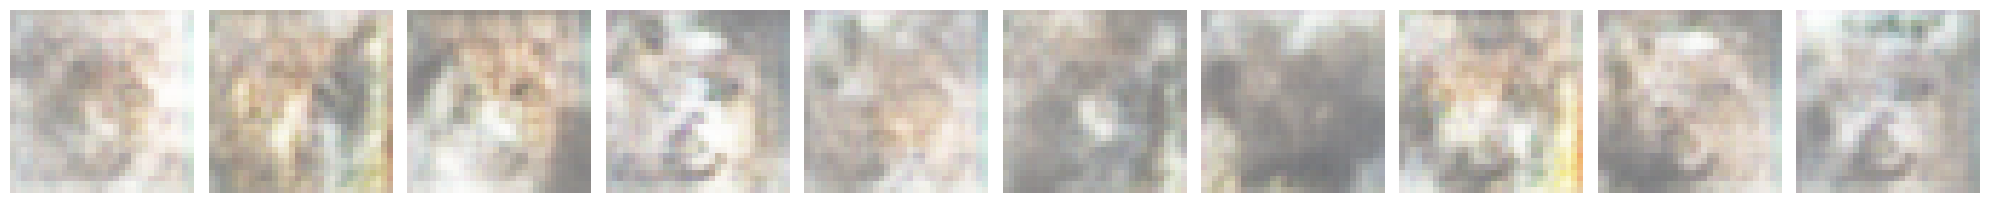

epoch:  170
1/1 [==============================] - 0s 144ms/step


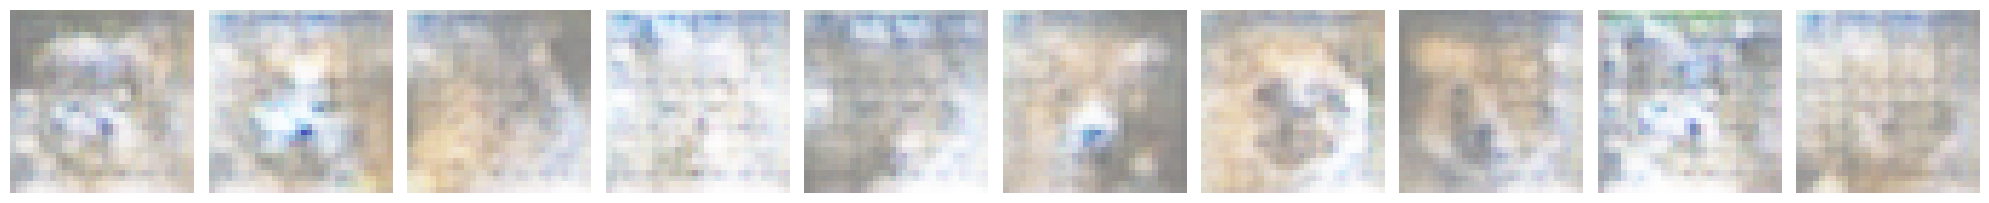

epoch:  180
1/1 [==============================] - 0s 137ms/step


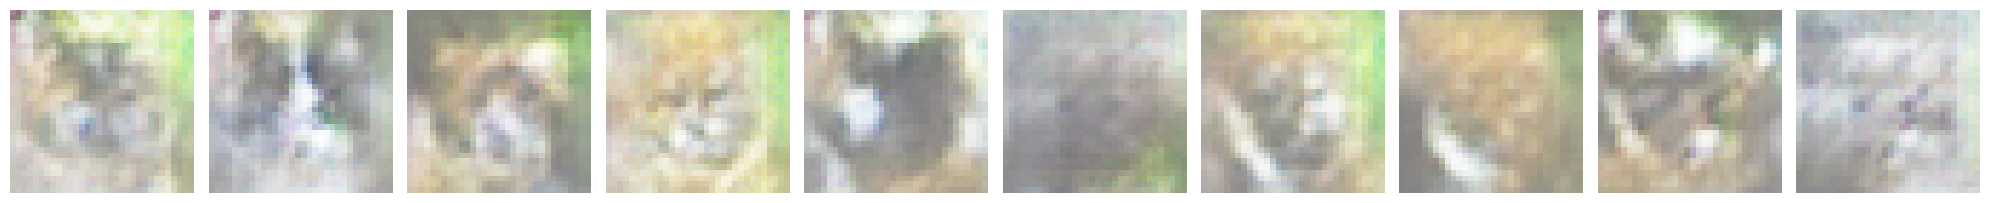

epoch:  190
1/1 [==============================] - 0s 136ms/step


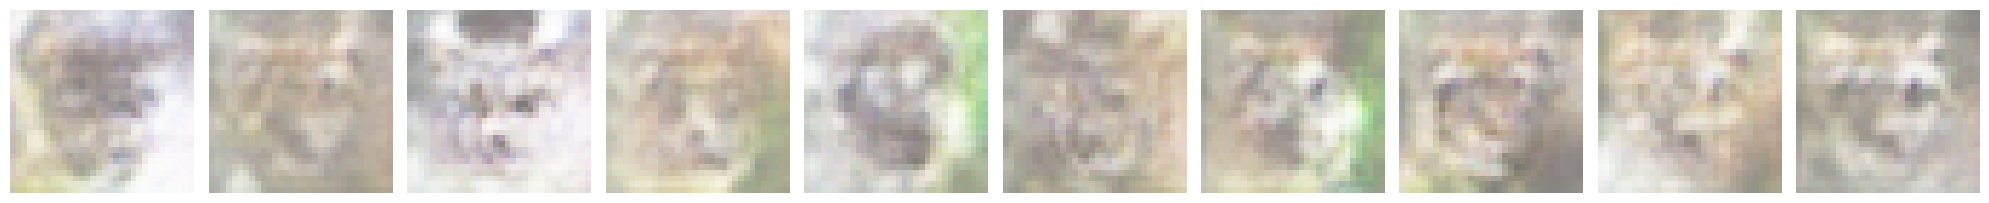

epoch:  200
1/1 [==============================] - 0s 140ms/step


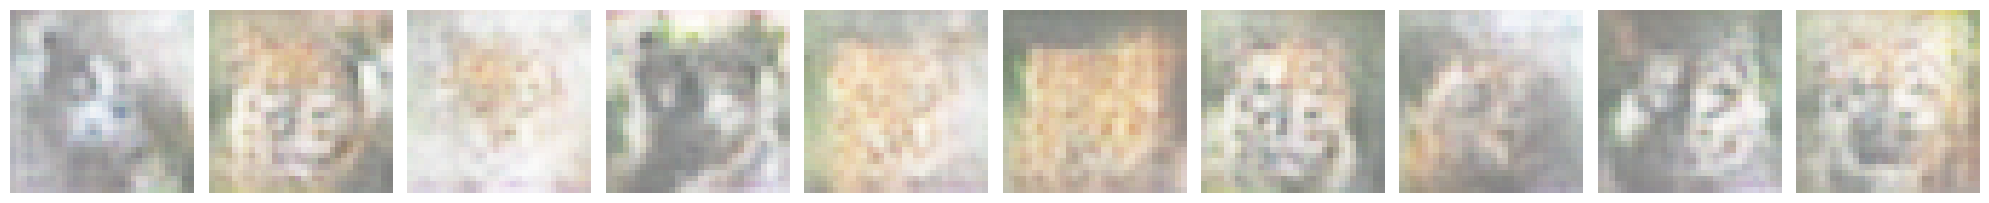

In [122]:
train_model(epochs, batch_size)